In [455]:
%pylab inline
import numpy as np
from scipy.spatial.distance import cdist
import sys
sys.path.append("../")
import sgd
reload(sgd)
import theano
import theano.tensor as T
import topogen
import sklearn.datasets
import util
import cPickle as pickle
import exputil

import sklearn.metrics

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(1600, 1600)


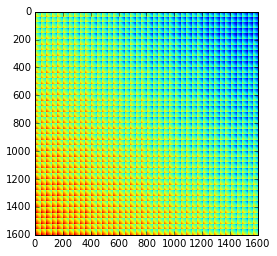

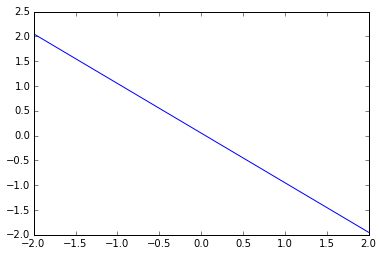

In [457]:
import kernels
reload(kernels)
reload(exputil)

def kern(sigma):
    def kern_func(X, theta):
        translation_vectors = X.reshape((X.shape[0], 1, -1)) - X.reshape((1, X.shape[0], -1))
        d = ((translation_vectors)).sum(2) 
        kern = d # T.exp(-d/(2*sigma**2))
        return kern
    return kern_func

kern_func = kern(1.0) # , 3.0)

kern_f = exputil.make_kern_f(kern_func)
N = 40
x = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, x)
points = np.array([xv.flatten(), yv.flatten()]).T
#points = np.meshgrid()
r  = kern_f(points, None)
print r.shape
pylab.imshow(r, interpolation='nearest')
pylab.figure()
pylab.imshow(r[N**2/2 + N/2].reshape((N, N)), interpolation='nearest')
pylab.figure()
pylab.plot(x, r[N**2/2 + N/2].reshape((N, N))[N/2])

(200, 2)
(200, 200)
(200, 200)


<matplotlib.colorbar.Colorbar instance at 0x7f0286952c20>

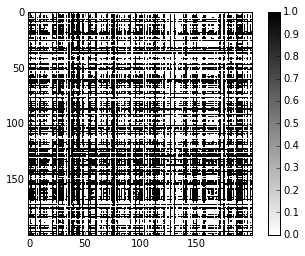

In [460]:
reload(sgd)
import losses
reload(losses)
N = 200
D = 3

lossobj = losses.Logistic(0.0)

#xtrue = np.random.normal(0, 1, (N, D))
xtrue = topogen.sample_sphere(N, D) + np.random.normal(0, 0.0001, (N, D))
print xtrue.shape
print kern_f(xtrue, None).shape
kern_val = kern_f(xtrue, None)
obs = lossobj.obs_forward(kern_val)
print obs.shape

obs_frac = 0.90
obsvalid = np.random.rand(*obs.shape) < obs_frac

xinit = np.random.normal(0, 1, (N, D))
pylab.imshow(obs, interpolation='nearest', cmap=pylab.cm.gray_r)
pylab.colorbar()

In [465]:
### 
reload(sgd)
reload(exputil)
ITERS = 40000

alpha = 0.1
kfold_cv = 10
xinit = np.random.normal(0, 5, (N, D))

res = exputil.run_cv_exp(kern_func, lossobj.cost(), 
               xinit, None,  obs,  lossobj.obs_forward, kfold_cv, batch_size=40, 
               alpha=alpha, iters=ITERS, use_adagrad=True, partition_batch=True, 
                         theta_inference=False, 
               verbose=True, verbose_iter=1000, folds_to_run=1)


../sgd.py:346: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: theta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
../sgd.py:351: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: theta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')


Running CV 0
0 obj= -226851.46641 ||grad||= 2500.98605164 ||x||= 19.0029250113 0.00
1000 obj= -4228.11596328 ||grad||= 131.980721271 ||x||= 15.6019342391 0.03
2000 obj= -4150.32704141 ||grad||= 138.864812862 ||x||= 16.1277348917 0.07
3000 obj= -4123.69621534 ||grad||= 124.517037172 ||x||= 16.4524572253 0.10
4000 obj= -4110.93547021 ||grad||= 110.986860739 ||x||= 16.6692562529 0.13
5000 obj= -4102.77957052 ||grad||= 133.866083832 ||x||= 16.834408461 0.16
6000 obj= -4100.51780023 ||grad||= 106.07099721 ||x||= 16.9579547179 0.20
7000 obj= -4096.39412927 ||grad||= 113.233790633 ||x||= 17.0621239034 0.23
8000 obj= -4094.60824425 ||grad||= 101.616994873 ||x||= 17.1476923346 0.26
9000 obj= -4091.56761068 ||grad||= 106.175677061 ||x||= 17.2194873019 0.29
10000 obj= -4090.03824736 ||grad||= 103.308952011 ||x||= 17.2830624887 0.33
11000 obj= -4090.41578033 ||grad||= 155.276326149 ||x||= 17.3326167679 0.36
12000 obj= -4088.90601244 ||grad||= 106.119023463 ||x||= 17.3794844208 0.39
13000 obj= -408

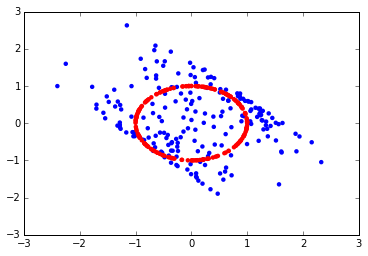

In [466]:
x_est = res[0]['x_est']
est_params = res[0]['est_params']
missing_pos = res[0]['missing_pos']
true_vals = res[0]['true_vals']
est_vals = res[0]['est_vals']
true_params = kern_val[missing_pos[:, 0], missing_pos[:, 1]]
pylab.scatter(x_est[:, 0], x_est[:, 1], edgecolor='none')
pylab.scatter(xtrue[:, 0], xtrue[:, 1], c='r', edgecolor='none')


In [468]:

kern_val_est = kern_f(x_est, None)
obs_est = lossobj.obs_forward(kern_val_est)
pylab.figure(figsize=(20, 4))

tgt = 80
pylab.plot(kern_val[tgt], c='k')

pylab.plot(kern_val_est[tgt], c='r', alpha=0.3, linewidth=2)

pylab.figure(figsize=(20, 4))
pylab.plot(obs[tgt], c='k')
pylab.scatter(range(N), obs_est[tgt],  c='r', alpha=1)
#pylab.ylim(-0.5, 1.5)
pylab.xlim(0, N)

(0, 200)

(0, 200)

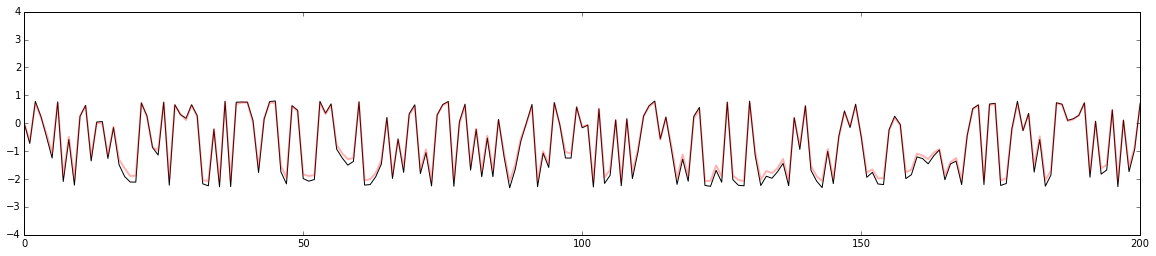

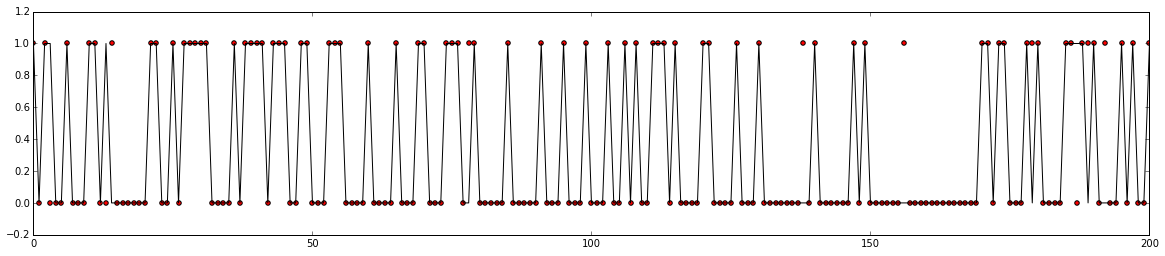

In [469]:


pylab.figure(figsize=(20, 4))

pylab.plot(est_params, c='k')

pylab.plot(true_params, c='r', alpha=0.3, linewidth=2)
pylab.xlim(0, 200)

pylab.figure(figsize=(20, 4))
pylab.plot(true_vals, c='k')
pylab.scatter(range(len(est_vals)), est_vals,  c='r', alpha=1)
#pylab.ylim(-0.5, 1.5)
pylab.xlim(0, N)

In [397]:
### 
reload(sgd)
reload(exputil)

for ITERS in [1000, 2000, 5000, 10000, 20000, 50000, 100000]:
    

    alpha = 0.1
    kfold_cv = 10
    xinit = np.random.normal(0, 5, (N, D))
    
    res = exputil.run_cv_exp(kern_func, lossobj.cost(), 
                   xinit, obs, lossobj.obs_forward, kfold_cv, batch_size=40, 
                   alpha=alpha, iters=ITERS, use_adagrad=True, seed=None, 
                   verbose=True, verbose_iter=1000, folds_to_run=1)



    fpr, tpr, th = sklearn.metrics.roc_curve(res[0]['true_vals'],
                                             res[0]['est_params'])
    pylab.plot(fpr, tpr, label=ITERS)
pylab.legend(loc='lower right')

Running CV 0
0 obj= -53939.6106482 ||grad||= 296.958855101 ||x||= 19.411170162 0.00
Running CV 0
0 obj= -52850.5523687 ||grad||= 174.695262336 ||x||= 19.2979303754 0.00
1000 obj= -14371.6891374 ||grad||= 134.243555209 ||x||= 15.2898671272 0.01
Running CV 0
0 obj= -54259.0239613 ||grad||= 196.275546379 ||x||= 20.1716662269 0.00
1000 obj= -14668.9701176 ||grad||= 94.4741032341 ||x||= 16.2121587299 0.01
2000 obj= -11445.3503611 ||grad||= 76.7152372195 ||x||= 14.7836433396 0.01
3000 obj= -10503.6575024 ||grad||= 76.3038440595 ||x||= 14.440672112 0.02
4000 obj= -10010.5637975 ||grad||= 61.1390297631 ||x||= 14.3079919775 0.03
Running CV 0
0 obj= -54060.6042604 ||grad||= 184.049356646 ||x||= 19.2600234661 0.00
1000 obj= -19578.294342 ||grad||= 114.303488307 ||x||= 16.9183945619 0.01
2000 obj= -15919.2671579 ||grad||= 55.3536271088 ||x||= 17.150501954 0.01
3000 obj= -15278.8988464 ||grad||= 52.8774231361 ||x||= 17.2568477493 0.02
4000 obj= -15088.7483354 ||grad||= 63.1640164557 ||x||= 17.28553

Running CV 0
0 obj= -53436.0969323 ||grad||= 181.1446156 ||x||= 18.458132345 0.00
1000 obj= -16952.5890613 ||grad||= 90.0141559754 ||x||= 18.3524318531 0.01
2000 obj= -16175.3059212 ||grad||= 65.9514772365 ||x||= 19.1361030738 0.01
3000 obj= -15990.0910585 ||grad||= 68.2089990089 ||x||= 19.4801769281 0.02
4000 obj= -15915.0590859 ||grad||= 60.866375165 ||x||= 19.6601418494 0.03
5000 obj= -15894.156068 ||grad||= 65.4371065598 ||x||= 19.8027448646 0.04
6000 obj= -15882.7099349 ||grad||= 70.4748622189 ||x||= 19.8710523798 0.04
7000 obj= -15878.8973933 ||grad||= 60.1541198108 ||x||= 19.9220887575 0.05
8000 obj= -15876.7636038 ||grad||= 69.3917715258 ||x||= 19.9500242921 0.06
9000 obj= -15872.7049513 ||grad||= 58.8700986672 ||x||= 19.9748667603 0.06
10000 obj= -15871.2852982 ||grad||= 57.0715534044 ||x||= 19.9967735401 0.07
11000 obj= -15870.6251683 ||grad||= 68.9278074421 ||x||= 19.9969102319 0.08
12000 obj= -15868.6890857 ||grad||= 56.0225929431 ||x||= 19.970619459 0.09
13000 obj= -15869.

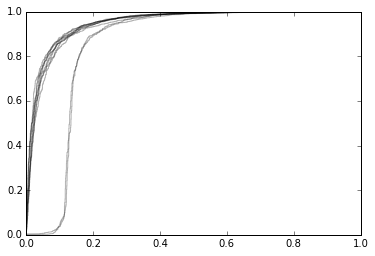

In [443]:
### 
reload(sgd)
reload(exputil)

ITERS = 50000    

alpha = 0.1
kfold_cv = 10
xinit = np.random.normal(0, 5, (N, D))
res = exputil.run_cv_exp(kern_func, lossobj.cost(), 
               xinit, obs, lossobj.obs_forward, kfold_cv, batch_size=40, 
               alpha=alpha, iters=ITERS, use_adagrad=True,  
               verbose=True, verbose_iter=1000)


for ri, r in enumerate(res):
    fpr, tpr, th = sklearn.metrics.roc_curve(r['true_vals'],
                                             r['est_params'])
    pylab.plot(fpr, tpr, c='k', alpha=0.3)
pylab.legend(loc='lower right')